# 🏥 Fine-Tuning YOLOv8 - GynSurge Dataset

**MedVision AI - Detecção de Instrumentos Cirúrgicos**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_REPO/notebooks/FINE_TUNING_GYNSURGE_COLAB.ipynb)

---

## 📋 Checklist Antes de Começar:

- [ ] **GPU Ativada**: Runtime > Change runtime type > **GPU (T4)**
- [ ] **Dataset Compactado**: `Instrument_Anatomy_Original_Dataset.zip` pronto
- [ ] **Tempo disponível**: ~2-3 horas para treinamento completo

---

## 🎯 O que este notebook faz:

1. ✅ Instala dependências (YOLOv8, bibliotecas)
2. ✅ Faz upload do dataset (suporta Google Drive ou upload direto)
3. ✅ Converte COCO JSON → Formato YOLO
4. ✅ Treina modelo com Transfer Learning
5. ✅ Valida e testa o modelo
6. ✅ Download do modelo treinado

---

## 🚀 Passo 1: Setup Inicial

In [1]:
# Instala dependências
!pip install -q ultralytics roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 145.1 MB/s eta 0:00:00


In [7]:
# Verifica GPU
import torch
print(f"🔥 CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  GPU não detectada! Ative em Runtime > Change runtime type > GPU")

🔥 CUDA disponível: True
✅ GPU: Tesla T4
💾 VRAM: 14.6 GB


## 📤 Passo 2: Upload do Dataset

In [4]:
from google.colab import drive
import os

drive.mount('/content/drive')

# AJUSTE O CAMINHO DO SEU DATASET AQUI!
# Exemplo: Se seu arquivo está em "Meu Drive/MedVision_AI/Instrument_Anatomy_Original_Dataset.zip"
DATASET_ZIP_PATH = "/content/drive/MyDrive/Colab Notebooks/FASE 4/MedVision_AI/Instrument_Anatomy_Original_Dataset.zip"

# Pasta onde salvaremos o modelo treinado (mesma pasta do dataset)
OUTPUT_DRIVE_FOLDER = os.path.dirname(DATASET_ZIP_PATH)

print(f"📂 Dataset ZIP: {DATASET_ZIP_PATH}")
print(f"💾 Modelos serão salvos em: {OUTPUT_DRIVE_FOLDER}")

# Extrair dataset
!unzip -q "{DATASET_ZIP_PATH}" -d /content/dataset
print("✅ Dataset extraído!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Dataset ZIP: /content/drive/MyDrive/Colab Notebooks/FASE 4/MedVision_AI/Instrument_Anatomy_Original_Dataset.zip
💾 Modelos serão salvos em: /content/drive/MyDrive/Colab Notebooks/FASE 4/MedVision_AI
✅ Dataset extraído!


## 🔄 Passo 3: Converter COCO → YOLO

In [6]:
import json
import shutil
from pathlib import Path
from collections import defaultdict
import random

def convert_coco_to_yolo(dataset_root, output_dir, use_instruments=True, use_anatomy=True):
    """
    Converte dataset COCO JSON para formato YOLO TXT

    Args:
        dataset_root: Raiz do dataset (contém anatomy.json e instruments.json)
        output_dir: Diretório de saída
        use_instruments: Incluir detecção de instrumentos cirúrgicos (instruments.json)
        use_anatomy: Incluir detecção de órgãos/anatomia (anatomy.json)
    """
    dataset_root = Path(dataset_root)
    output_dir = Path(output_dir)

    # Criar estrutura de pastas
    for split in ['train', 'val', 'test']:
        (output_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
        (output_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)

    # Coletar dados de ambos os JSONs
    all_images = []
    all_annotations = defaultdict(list)
    categories = {}
    category_offset = 0  # Para evitar conflito de IDs entre os dois JSONs

    print("🔍 Preparando dataset combinado...")
    print(f"   ✅ Instrumentos cirúrgicos: {'SIM' if use_instruments else 'NÃO'}")
    print(f"   ✅ Órgãos/Anatomia: {'SIM' if use_anatomy else 'NÃO'}")
    print()

    # Lista de arquivos JSON para processar
    json_files_to_process = []

    if use_instruments:
        instruments_json = dataset_root / 'instruments.json'
        if instruments_json.exists():
            json_files_to_process.append(('instruments', instruments_json))
        else:
            print(f"⚠️  Arquivo não encontrado: {instruments_json}")

    if use_anatomy:
        anatomy_json = dataset_root / 'anatomy.json'
        if anatomy_json.exists():
            json_files_to_process.append(('anatomy', anatomy_json))
        else:
            print(f"⚠️  Arquivo não encontrado: {anatomy_json}")

    if not json_files_to_process:
        print("❌ Nenhum arquivo JSON encontrado!")
        return None

    print(f"✅ Processando {len(json_files_to_process)} arquivos JSON...\n")

    # Processar cada JSON
    for json_type, json_file in json_files_to_process:
        print(f"📄 Processando: {json_file.name} ({json_type})")

        with open(json_file, 'r') as f:
            data = json.load(f)

        # Extrair categorias com offset para evitar conflito de IDs
        json_categories = {}
        for cat in data.get('categories', []):
            new_id = cat['id'] + category_offset
            category_name = cat['name']

            # Adicionar prefixo para diferenciar (opcional)
            if json_type == 'anatomy':
                display_name = f"organ_{category_name}"
            else:
                display_name = category_name

            categories[new_id] = display_name
            json_categories[cat['id']] = new_id  # Mapa ID antigo -> ID novo

        print(f"   📊 {len(json_categories)} classes encontradas")

        # Extrair imagens
        img_id_offset = len(all_images)  # Offset para IDs de imagens
        for img in data.get('images', []):
            img_copy = img.copy()
            img_copy['original_id'] = img['id']
            img_copy['id'] = img['id'] + img_id_offset
            img_copy['json_type'] = json_type
            all_images.append(img_copy)

        print(f"   🖼️  {len(data.get('images', []))} imagens")

        # Extrair anotações com IDs ajustados
        for ann in data.get('annotations', []):
            ann_copy = ann.copy()
            ann_copy['image_id'] = ann['image_id'] + img_id_offset
            ann_copy['category_id'] = json_categories[ann['category_id']]
            all_annotations[ann_copy['image_id']].append(ann_copy)

        print(f"   🏷️  {len(data.get('annotations', []))} anotações\n")

        # Atualizar offset para próximo JSON
        category_offset = max(categories.keys()) + 1 if categories else 0

    print(f"📊 DATASET COMBINADO:")
    print(f"   Total de imagens: {len(all_images)}")
    print(f"   Total de classes: {len(categories)}")
    print(f"   Total de anotações: {sum(len(anns) for anns in all_annotations.values())}")
    print(f"\n🏷️  Classes detectáveis:")
    for cat_id, cat_name in sorted(categories.items()):
        print(f"   [{cat_id}] {cat_name}")
    print()

    # Dividir dataset por TIPO (insseg e ganseg separados) para evitar data leakage
    # Separar imagens por pasta de origem
    insseg_images = [img for img in all_images if img.get('path', '').startswith('insseg')]
    ganseg_images = [img for img in all_images if img.get('path', '').startswith('ganseg')]

    print(f"📁 Distribuição por pasta:")
    print(f"   INSSEG (instrumentos): {len(insseg_images)} imagens")
    print(f"   GANSEG (anatomia): {len(ganseg_images)} imagens")
    print()

    # Embaralhar cada grupo separadamente
    random.shuffle(insseg_images)
    random.shuffle(ganseg_images)

    # Dividir cada grupo: 70% train, 20% val, 10% test
    def split_images(images, train_pct=0.7, val_pct=0.2):
        n_train = int(len(images) * train_pct)
        n_val = int(len(images) * val_pct)
        return {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

    insseg_splits = split_images(insseg_images)
    ganseg_splits = split_images(ganseg_images)

    # Combinar splits
    splits = {
        'train': insseg_splits['train'] + ganseg_splits['train'],
        'val': insseg_splits['val'] + ganseg_splits['val'],
        'test': insseg_splits['test'] + ganseg_splits['test']
    }

    print(f"📊 Divisão Train/Val/Test:")
    for split_name in ['train', 'val', 'test']:
        n_insseg = len([img for img in splits[split_name] if img.get('path', '').startswith('insseg')])
        n_ganseg = len([img for img in splits[split_name] if img.get('path', '').startswith('ganseg')])
        print(f"   {split_name.upper():5s}: {len(splits[split_name]):4d} total (INSSEG: {n_insseg}, GANSEG: {n_ganseg})")
    print()

    # Converter para YOLO format
    stats = {'train': 0, 'val': 0, 'test': 0}

    for split_name, images in splits.items():
        print(f"🔄 Processando split '{split_name}': {len(images)} imagens")

        for idx, img in enumerate(images):
            if idx % 500 == 0 and idx > 0:
                print(f"   Processadas {idx}/{len(images)} imagens...")

            # Caminho da imagem original
            img_path = img.get('path', '')
            if not img_path:
                img_path = img.get('file_name', '')

            # Encontrar arquivo de imagem
            img_file = dataset_root / img_path.lstrip('/')
            if not img_file.exists():
                # Buscar recursivamente como fallback
                candidates = list(dataset_root.rglob(img['file_name']))
                if candidates:
                    img_file = candidates[0]
                else:
                    continue

            # Copiar imagem
            dst_img = output_dir / 'images' / split_name / img['file_name']
            shutil.copy(img_file, dst_img)

            # Converter anotações
            img_id = img['id']
            annotations = all_annotations.get(img_id, [])

            if not annotations:
                continue  # Pular imagens sem anotações

            label_file = output_dir / 'labels' / split_name / f"{Path(img['file_name']).stem}.txt"

            with open(label_file, 'w') as f:
                for ann in annotations:
                    # COCO bbox format: [x, y, width, height] (absolute pixels)
                    # YOLO format: [class_id, x_center, y_center, width, height] (normalized 0-1)

                    bbox = ann['bbox']
                    x, y, w, h = bbox

                    # Normalizar
                    img_w = img['width']
                    img_h = img['height']

                    x_center = (x + w / 2) / img_w
                    y_center = (y + h / 2) / img_h
                    w_norm = w / img_w
                    h_norm = h / img_h

                    # Classe (YOLO usa índice começando em 0)
                    cat_id = ann['category_id']
                    class_idx = list(categories.keys()).index(cat_id)

                    # Escrever linha
                    f.write(f"{class_idx} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

            stats[split_name] += 1

        print(f"   ✅ Processadas: {stats[split_name]} imagens com anotações")

    # Criar data.yaml para YOLOv8
    yaml_content = f"""# MedVision AI - GynSurge Dataset (Instrumentos + Anatomia)
path: {output_dir.absolute()}
train: images/train
val: images/val
test: images/test

# Classes (Instrumentos Cirúrgicos + Órgãos/Anatomia)
nc: {len(categories)}
names: {list(categories.values())}
"""

    with open(output_dir / 'data.yaml', 'w') as f:
        f.write(yaml_content)

    print()
    print("=" * 70)
    print("✅ CONVERSÃO CONCLUÍDA!")
    print("=" * 70)
    print(f"📁 Dataset YOLO salvo em: {output_dir}")
    print(f"📊 Train: {stats['train']}, Val: {stats['val']}, Test: {stats['test']}")
    print(f"🏷️  Total de classes: {len(categories)} (instrumentos + órgãos)")
    print("=" * 70)

    return output_dir / 'data.yaml'

# ========================================
# CONFIGURAÇÃO: Escolha o que treinar
# ========================================
USE_INSTRUMENTS = True  # Detectar instrumentos cirúrgicos
USE_ANATOMY = True      # Detectar órgãos/anatomia

print("🏥 CONFIGURAÇÃO DE TREINAMENTO:")
print(f"   🔧 Instrumentos Cirúrgicos: {'✅ ATIVO' if USE_INSTRUMENTS else '❌ DESATIVADO'}")
print(f"   🫀 Órgãos/Anatomia: {'✅ ATIVO' if USE_ANATOMY else '❌ DESATIVADO'}")
print()

# Executar conversão
DATA_YAML = convert_coco_to_yolo(
    dataset_root='/content/dataset/Instrument_Anatomy_Original_Dataset',
    output_dir='/content/yolo_dataset',
    use_instruments=USE_INSTRUMENTS,
    use_anatomy=USE_ANATOMY
)

print(f"\n✅ Arquivo de configuração: {DATA_YAML}")

🏥 CONFIGURAÇÃO DE TREINAMENTO:
   🔧 Instrumentos Cirúrgicos: ✅ ATIVO
   🫀 Órgãos/Anatomia: ✅ ATIVO

🔍 Preparando dataset combinado...
   ✅ Instrumentos cirúrgicos: SIM
   ✅ Órgãos/Anatomia: SIM

✅ Processando 2 arquivos JSON...

📄 Processando: instruments.json (instruments)
   📊 23 classes encontradas
   🖼️  5774 imagens
   🏷️  14913 anotações

📄 Processando: anatomy.json (anatomy)
   📊 8 classes encontradas
   🖼️  818 imagens
   🏷️  1165 anotações

📊 DATASET COMBINADO:
   Total de imagens: 6592
   Total de classes: 31
   Total de anotações: 16078

🏷️  Classes detectáveis:
   [1] instrument
   [2] grasper
   [3] irrigator
   [4] morcellator
   [5] bipolar-forceps
   [6] needle
   [7] sealer-divider
   [8] trocar
   [9] thread
   [10] scissors
   [11] hook
   [12] needle-holder
   [13] knot-pusher
   [14] in-cannula
   [15] clip-applier
   [16] suture-carrier
   [17] clip
   [18] thread-fragment
   [27] trocar-sleeve
   [28] cannula
   [29] corkscrew
   [30] colpotomizer
   [31] glove
 

## 🎯 Passo 4: Treinar Modelo YOLOv8

In [7]:
from ultralytics import YOLO

# Carregar modelo pre-trained
model = YOLO('yolov8n.pt')  # nano para velocidade

# Hiperparâmetros otimizados para instrumentos cirúrgicos
results = model.train(
    data=DATA_YAML,
    epochs=100,
    imgsz=640,
    batch=16,
    device=0,  # GPU

    # Otimizador
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,

    # Augmentação específica para cirurgia (sem rotação extrema)
    degrees=0.0,      # Sem rotação (cirurgias têm orientação fixa)
    flipud=0.0,       # Sem flip vertical
    fliplr=0.5,       # Flip horizontal OK

    # Performance
    cache=True,       # Cache imagens na RAM para velocidade
    amp=True,         # Automatic Mixed Precision
    workers=8,

    # Output
    project='/content/runs/train',
    name='gynsurge_yolov8n',
    exist_ok=True,
    verbose=True
)

print("\n✅ Treinamento concluído!")
print(f"📊 Melhores weights: /content/runs/train/gynsurge_yolov8n/weights/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=

## 📊 Passo 5: Visualizar Resultados

📈 Curvas de Loss e Métricas:


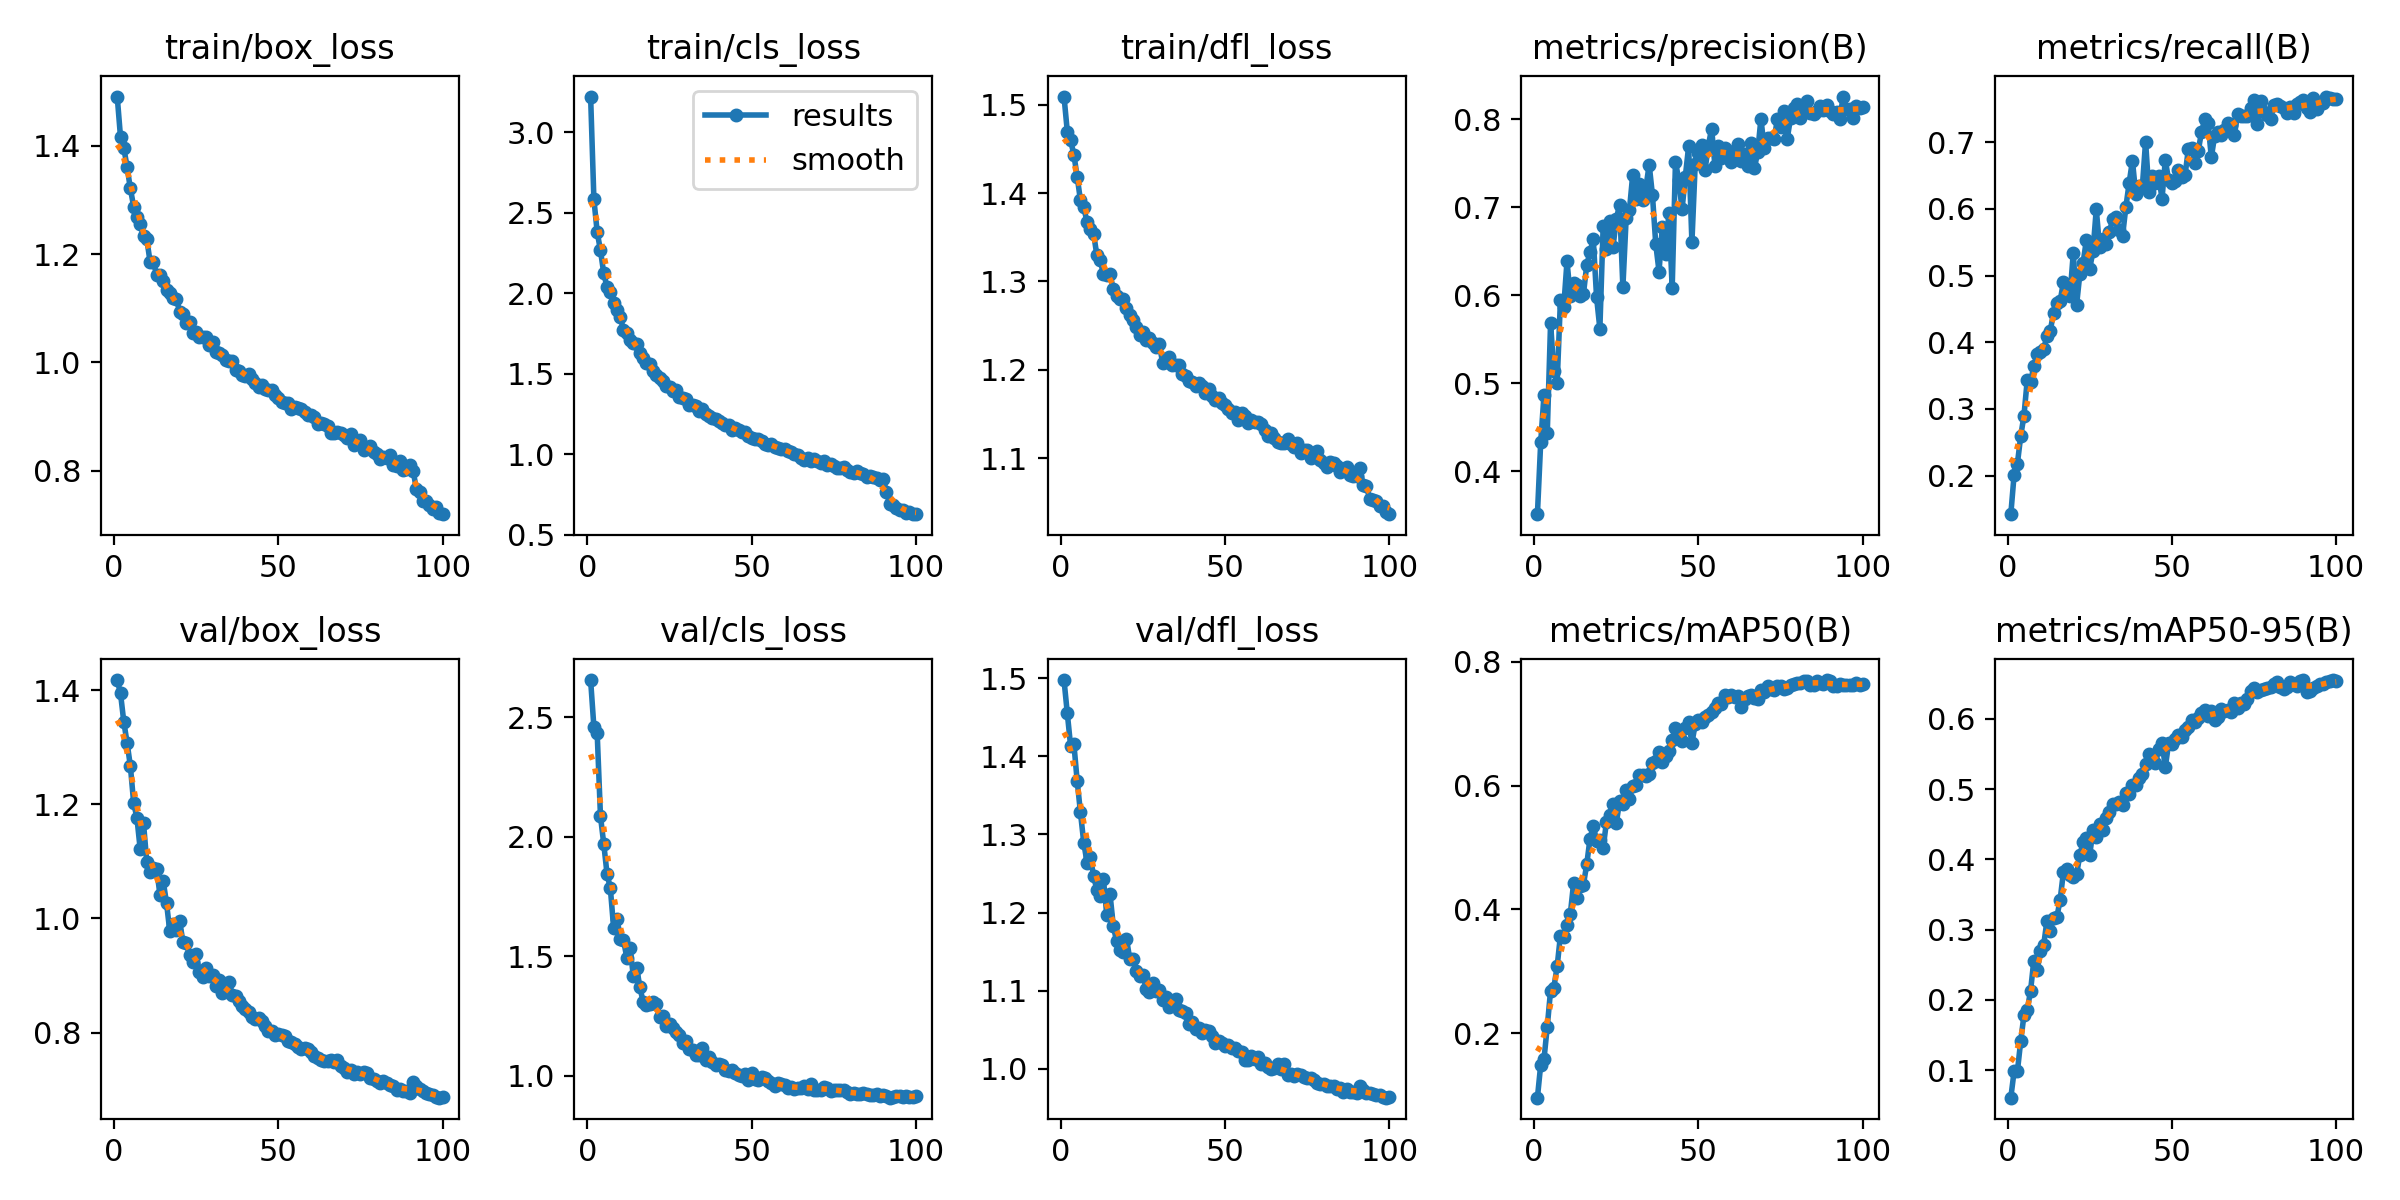


📊 Confusion Matrix:


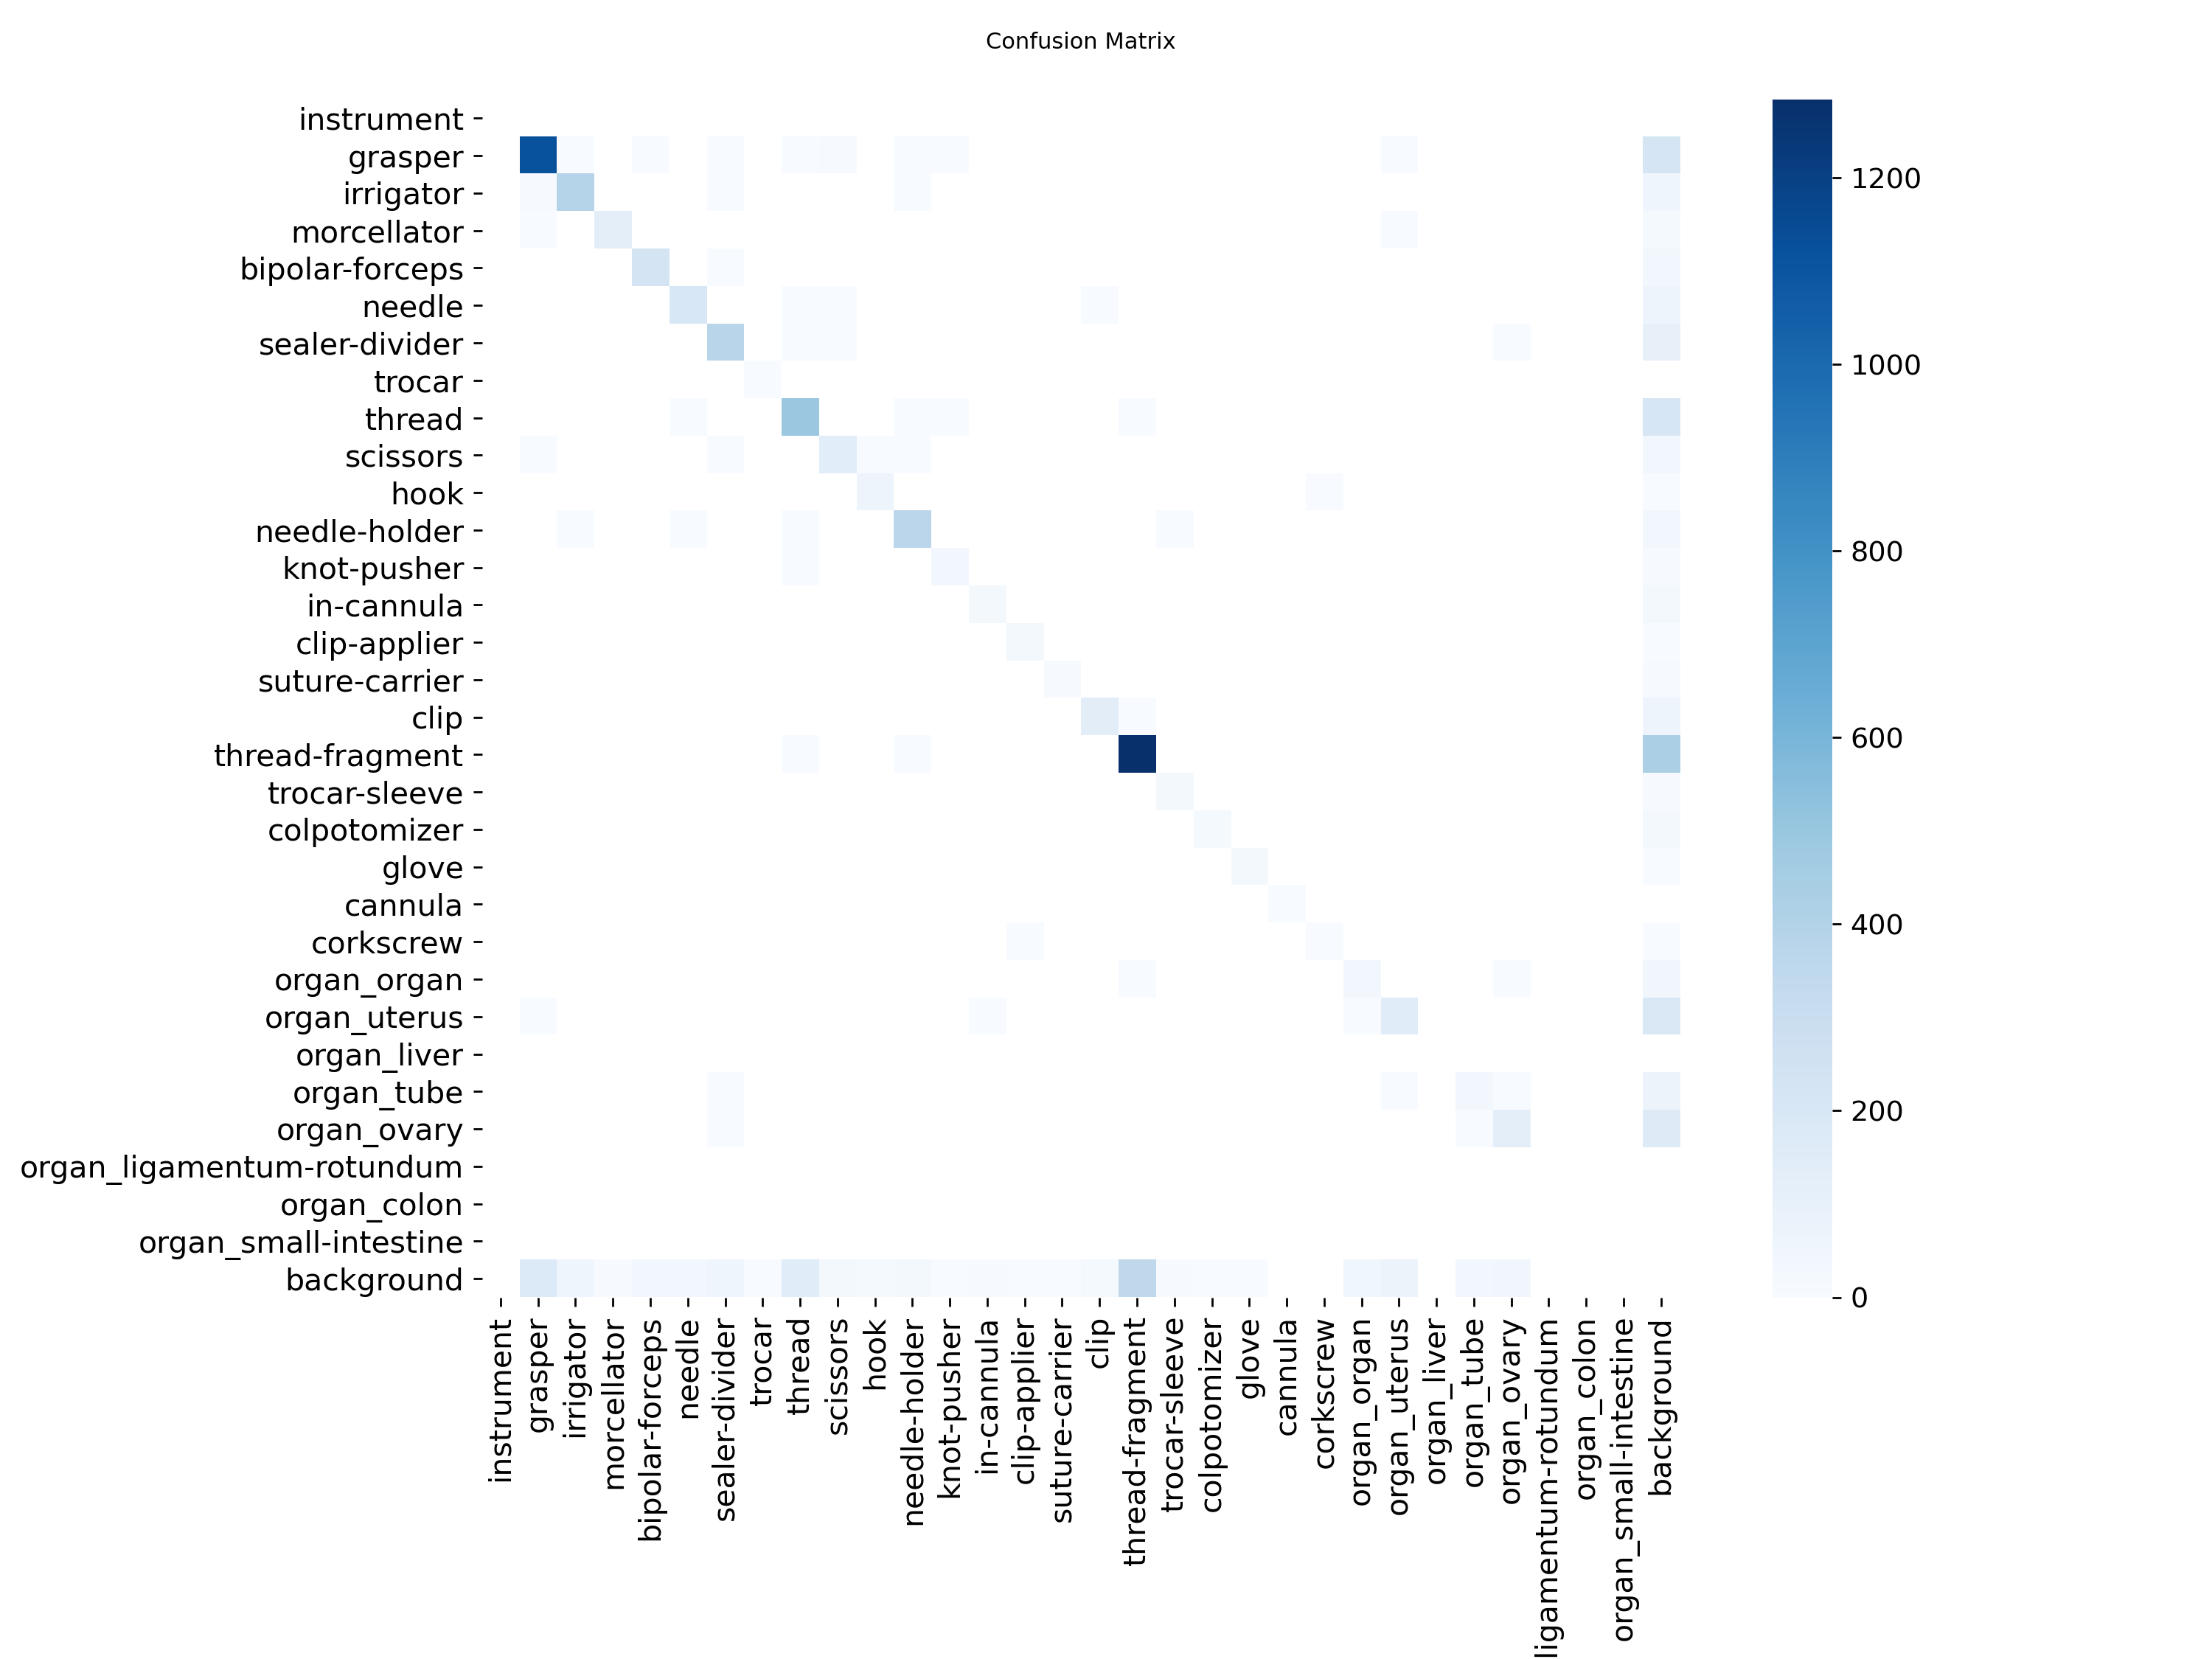


🎯 Exemplos de Predições:


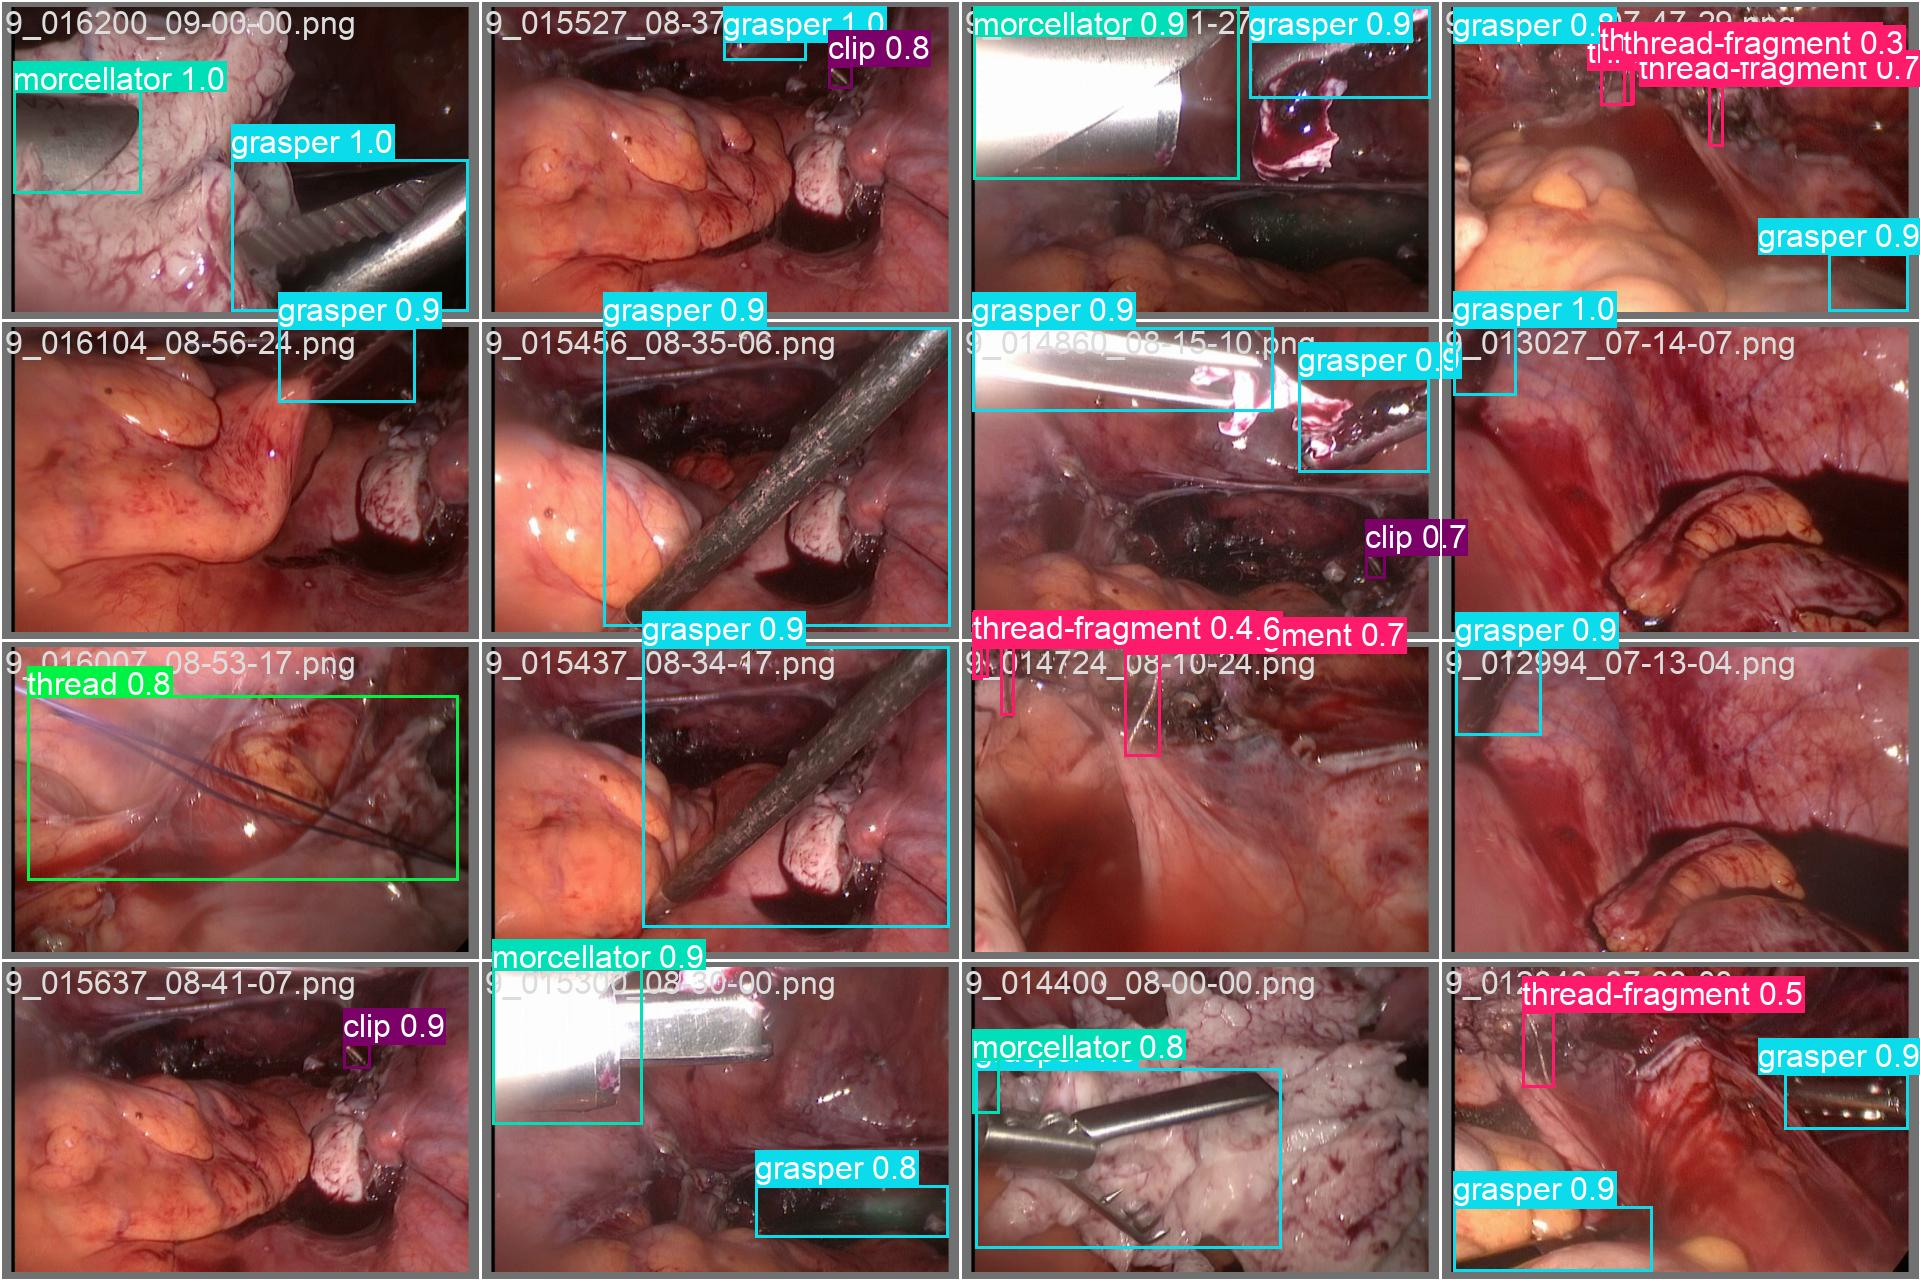

In [8]:
from IPython.display import Image, display

# Visualizar curvas de treinamento
print("📈 Curvas de Loss e Métricas:")
display(Image('/content/runs/train/gynsurge_yolov8n/results.png'))

# Confusion Matrix
print("\n📊 Confusion Matrix:")
display(Image('/content/runs/train/gynsurge_yolov8n/confusion_matrix.png'))

# Exemplos de predições no validation set
print("\n🎯 Exemplos de Predições:")
display(Image('/content/runs/train/gynsurge_yolov8n/val_batch0_pred.jpg'))

## ✅ Passo 6: Validar Modelo no Test Set

In [9]:
# Carregar melhor modelo
best_model = YOLO('/content/runs/train/gynsurge_yolov8n/weights/best.pt')

# Validar no test set
test_results = best_model.val(split='test')

print("\n📊 Métricas no Test Set:")
print(f"mAP50: {test_results.box.map50:.4f}")
print(f"mAP50-95: {test_results.box.map:.4f}")
print(f"Precision: {test_results.box.mp:.4f}")
print(f"Recall: {test_results.box.mr:.4f}")

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,011,693 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 78.9±17.2 MB/s, size: 521.0 KB)
val: Scanning /content/yolo_dataset/labels/test... 1565 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1565/1565 233.3it/s 6.7s
val: /content/yolo_dataset/images/test/0_000160_00-05-10.png: 2 duplicate labels removed
val: /content/yolo_dataset/images/test/0_000551_00-18-11.png: 9 duplicate labels removed
val: /content/yolo_dataset/images/test/0_000900_00-30-00.png: 2 duplicate labels removed
val: /content/yolo_dataset/images/test/0_001913_01-03-23.png: 1 duplicate labels removed
val: /content/yolo_dataset/images/test/0_002190_01-13-00.png: 2 duplicate labels removed
val: /content/yolo_dataset/images/test/0_002392_01-19-22.png: 2 duplicate labels removed
val: /content/yolo_dataset/images/test/0_002653_01-28-13.png: 2 duplicate labels removed


## 🧪 Passo 7: Testar em Imagem Individual


image 1/1 /content/yolo_dataset/images/test/2_002284_01-16-04.png: 448x640 1 sealer-divider, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/runs/detect/predict
✅ Testado em: /content/yolo_dataset/images/test/2_002284_01-16-04.png


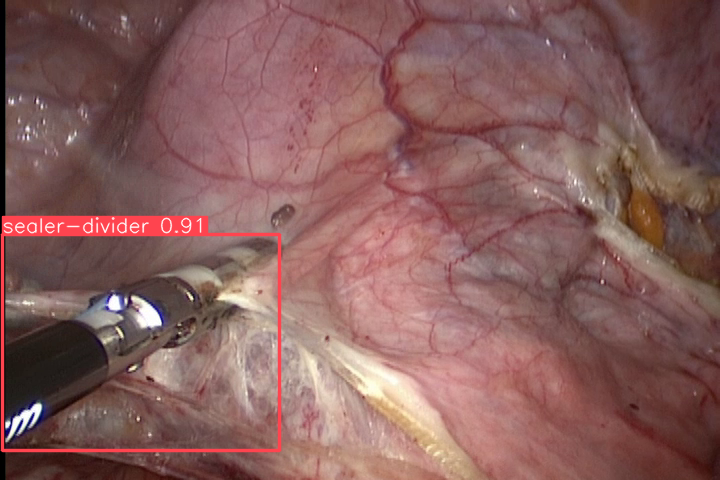

📁 Resultado salvo em disco em: /content/runs/detect/predict/2_002284_01-16-04.png


In [15]:
import glob
from pathlib import Path
from IPython.display import Image, display
import numpy as np
import PIL.Image
import io

# Pegar uma imagem aleatória do test set
test_images = glob.glob('/content/yolo_dataset/images/test/*.png') + \
              glob.glob('/content/yolo_dataset/images/test/*.jpg')

if test_images:
    test_img = test_images[0]

    # Fazer predição
    results = best_model.predict(test_img, save=True, conf=0.25)

    print(f"✅ Testado em: {test_img}")

    # Use results[0].plot() para obter a imagem anotada como um array NumPy
    im_array = results[0].plot()  # plot retorna um array NumPy RGB
    im = PIL.Image.fromarray(im_array[..., ::-1])  # Converter para PIL Image (RGB para BGR, se necessário, mas plot já deve ser RGB)

    # Salvar a imagem PIL para um buffer de bytes para exibição
    img_byte_arr = io.BytesIO()
    im.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()

    # Mostrar resultado
    display(Image(data=img_byte_arr, format='png'))

    print(f"📁 Resultado salvo em disco em: {results[0].save_dir}/{Path(test_img).name}") # Apenas para informação

else:
    print("❌ Nenhuma imagem encontrada no test set!")

## 💾 Passo 8: Salvar Modelo no Google Drive (AUTOMÁTICO!)

In [16]:
import shutil
from datetime import datetime


# Caminhos
BEST_PT = '/content/runs/train/gynsurge_yolov8n/weights/best.pt'
LAST_PT = '/content/runs/train/gynsurge_yolov8n/weights/last.pt'

# Nome com timestamp para versionamento
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_FILENAME = f'yolov8_gyneco_{timestamp}.pt'
OUTPUT_PATH = f"{OUTPUT_DRIVE_FOLDER}/{OUTPUT_FILENAME}"

print("💾 Salvando modelo treinado no Google Drive...")
print(f"📂 Origem: {BEST_PT}")
print(f"📂 Destino: {OUTPUT_PATH}")

# Copiar best.pt para Google Drive
shutil.copy(BEST_PT, OUTPUT_PATH)

# Também salvar uma cópia sem timestamp (sempre sobrescreve com a versão mais recente)
OUTPUT_LATEST = f"{OUTPUT_DRIVE_FOLDER}/yolov8_gyneco_LATEST.pt"
shutil.copy(BEST_PT, OUTPUT_LATEST)

# Opcional: Salvar last.pt também
OUTPUT_LAST = f"{OUTPUT_DRIVE_FOLDER}/yolov8_gyneco_last.pt"
shutil.copy(LAST_PT, OUTPUT_LAST)

print("\n✅ Modelo salvo automaticamente no Google Drive!")
print(f"✅ Versão com timestamp: {OUTPUT_FILENAME}")
print(f"✅ Versão LATEST (sempre atualizada): yolov8_gyneco_LATEST.pt")
print(f"✅ Last checkpoint: yolov8_gyneco_last.pt")
print(f"\n📁 Localização: {OUTPUT_DRIVE_FOLDER}")
print("\n🎉 Para usar no MedVision AI:")
print("   1. Baixe o arquivo 'yolov8_gyneco_LATEST.pt' do Google Drive")
print("   2. Renomeie para: yolov8_gyneco.pt")
print("   3. Copie para: backend/models_weights/yolov8_gyneco.pt")
print("   4. Reinicie o backend - modelo será carregado automaticamente!")

💾 Salvando modelo treinado no Google Drive...
📂 Origem: /content/runs/train/gynsurge_yolov8n/weights/best.pt
📂 Destino: /content/drive/MyDrive/Colab Notebooks/FASE 4/MedVision_AI/yolov8_gyneco_20260211_142012.pt

✅ Modelo salvo automaticamente no Google Drive!
✅ Versão com timestamp: yolov8_gyneco_20260211_142012.pt
✅ Versão LATEST (sempre atualizada): yolov8_gyneco_LATEST.pt
✅ Last checkpoint: yolov8_gyneco_last.pt

📁 Localização: /content/drive/MyDrive/Colab Notebooks/FASE 4/MedVision_AI

🎉 Para usar no MedVision AI:
   1. Baixe o arquivo 'yolov8_gyneco_LATEST.pt' do Google Drive
   2. Renomeie para: yolov8_gyneco.pt
   3. Copie para: backend/models_weights/yolov8_gyneco.pt
   4. Reinicie o backend - modelo será carregado automaticamente!


## 📥 Passo 9: Download Local (Opcional)

In [ ]:
from google.colab import files

# ⚠️  OPCIONAL: Só execute se quiser download direto pelo navegador
# O modelo JÁ ESTÁ SALVO no Google Drive automaticamente!

print("⚠️  O modelo já foi salvo automaticamente no Google Drive!")
print(f"📁 Localização: {OUTPUT_DRIVE_FOLDER}")
print("\n🔽 Se ainda assim quiser baixar pelo navegador:")
print("   Descomente as linhas abaixo e execute novamente")
print()

# Descomente as linhas abaixo para fazer download pelo navegador:
# print("📦 Criando ZIP com os modelos...")
# !zip -r /content/gynsurge_models.zip /content/runs/train/gynsurge_yolov8n/weights/
# print("⬇️  Iniciando download...")
# files.download('/content/gynsurge_models.zip')
# print("✅ Download concluído!")

---

## 🎉 Pronto! Seu Modelo Está Treinado e Salvo!

### 📊 O que foi feito:

✅ Dataset convertido de COCO → YOLO  
✅ Modelo YOLOv8n treinado por 100 épocas  
✅ Validação no test set concluída  
✅ **Modelo salvo AUTOMATICAMENTE no Google Drive!**

---

### 🚀 Próximos Passos:

#### 1️⃣ Baixar do Google Drive
No seu Google Drive, vá para: **`MedVision_AI/`** (ou pasta que você configurou)

Você encontrará:
- `yolov8_gyneco_LATEST.pt` ← **Use este!**
- `yolov8_gyneco_YYYYMMDD_HHMMSS.pt` ← Versão com timestamp
- `yolov8_gyneco_last.pt` ← Último checkpoint

#### 2️⃣ Integrar no Backend
```powershell
# No Windows
cd C:\dev\TechChallengeF04\medvision-ai\backend

# Renomear e copiar
copy "C:\Users\SEU_NOME\Downloads\yolov8_gyneco_LATEST.pt" models_weights\yolov8_gyneco.pt
```

#### 3️⃣ Reiniciar Backend
```powershell
cd C:\dev\TechChallengeF04\medvision-ai\backend
.\venv\Scripts\activate
uvicorn app.main:app --reload
```

Procure nos logs:
```
✅ Modelo YOLOv8 carregado: custom
✅ Classes detectáveis: X  (instrumentos cirúrgicos)
```

#### 4️⃣ Testar!
1. Acesse http://localhost:5174
2. Faça upload de vídeo cirúrgico real
3. **Veja os instrumentos sendo detectados!** 🎬

---

### 📈 Dicas para Melhorar o Modelo:

Se mAP50 < 0.5:
- Treinar mais épocas (150-200)
- Usar modelo maior: `YOLO('yolov8s.pt')` ou `yolov8m.pt`
- Ajustar data augmentation
- Verificar qualidade das anotações

Se está bom (mAP50 > 0.7):
- 🎉 Parabéns! Modelo excelente!
- Testar em vídeos reais
- Ajustar confidence threshold (0.25 → 0.3 ou 0.4)

---

**💡 Lembre-se**: O modelo está salvo no Google Drive e pode ser baixado a qualquer momento!